In [1]:
# import packages
import numpy as np
import cadquery as cq
from scipy.stats import qmc
import math
import itertools
import matplotlib.pyplot as plt
import os
import json
import copy
import random
import pickle

In [2]:
# load spherical code
# Read the JSON file as a dictionary
json_filepath = '/glade/u/home/joko/spherical-code/data/s_code.json'
with open(json_filepath, 'r') as json_file:
    s_code_dict = json.load(json_file)

# Print the dictionary to verify
print(s_code_dict)

{'4': [-0.577350269072, 0.577350269072, -0.577350269072, 0.577350269072, 0.577350269072, 0.577350269072, -0.577350269072, -0.577350269072, 0.577350269072, 0.577350269072, -0.577350269072, -0.577350269072], '5': [-0.14782559370880183, 0.8557801392177641, 0.495770054728061, 0.9298520676823501, -0.3330452755499896, -0.15638406779685032, -0.7820264758448114, -0.5227348665222011, -0.33938599028209954, -0.036123069457864206, -0.5056147808319168, 0.8620027942282061, 0.036123069583033664, 0.505614780103487, -0.8620027946502272], '6': [0.21254825592, -0.977150570601, 0.0, -0.977150570601, -0.21254825592, 0.0, -0.21254825592, 0.977150570601, 0.0, 0.977150570601, 0.21254825592, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, -1.0], '7': [-0.9476914051796328, -0.20521795145581753, 0.24447206987492645, 0.8503710682661693, 0.48308483448290185, 0.20856195470047173, -0.4995609516538522, 0.3276811928816585, -0.8019126457503652, -0.3344875986220292, 0.8899589445240679, 0.30998568262046483, 0.024203814844953528, -0.992443

Notes:
- (1.19, 5.75) are the 5th and 95th percentile values of aspect ratios of the prism face from "iceball_data_analysis.ipynb" notebook
- (9.44, 33.90) are also 5th/95th percentiles of basal Dmax (divided by 2)

In [23]:
'''
(1) Generate latin hypercube of initial parameters
Parameters: a, c/a, f_r0, f_hp, f_h0
Generate N samples using LHS
'''
N = 200 # of LHS samples
n_arm_min, n_arm_max = 4, 10
n_arms_list = list(range(n_arm_min, n_arm_max+1))
# define parameter ranges 
a_min, a_max = 9.44, 33.90 # microns
c_over_a_min, c_over_a_max = 1.19, 5.75 # unitless
f_r0_min, f_r0_max = 0.8, 1.25
f_hp_min, f_hp_max = 0.8, 1.2
f_h0_min, f_h0_max = 0.8, 1.2

# generate LHS
sampler = qmc.LatinHypercube(d = 5, optimization='random-cd')
samples = sampler.random(n=N)

# metric for quality of the samples
print(f'discrepancy metric: {qmc.discrepancy(samples)}')

# scale samples to bounds
l_bounds = [a_min, c_over_a_min, f_r0_min, f_hp_min, f_h0_min]
u_bounds = [a_max, c_over_a_max, f_r0_max, f_hp_max, f_h0_max]
param_list_1 = qmc.scale(samples, l_bounds, u_bounds)

discrepancy metric: 0.000142942585404926


discrepancy metric: 0.003285137260642612
discrepancy metric: 0.0011082924648913028
discrepancy metric: 0.0007773677883315955
discrepancy metric: 0.00048010096625450416
discrepancy metric: 0.0003758615477391647
discrepancy metric: 0.0002702635088007721
discrepancy metric: 0.00022597012468028588
discrepancy metric: 0.00019710673231321252
discrepancy metric: 0.0001636262193842608
discrepancy metric: 0.00017818651509693417
discrepancy metric: 0.00013431112351214303
discrepancy metric: 0.0001284713227864831
discrepancy metric: 0.00010300227952764196
discrepancy metric: 0.00010096832056860627
discrepancy metric: 8.808616262934166e-05
discrepancy metric: 8.396000589749875e-05
discrepancy metric: 7.579141445557269e-05
discrepancy metric: 7.238057183922564e-05
discrepancy metric: 7.946431758476535e-05
discrepancy metric: 6.370209305495145e-05


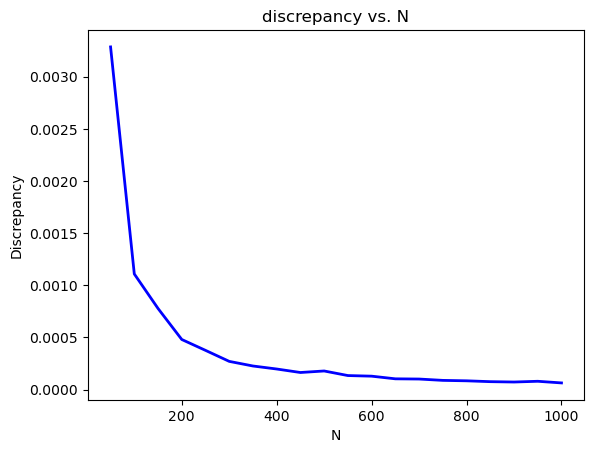

In [26]:
# plot discrepancy vs. N 
N_arr = np.arange(50, 1050, 50)
disc = []
for N in N_arr:
    n_arm_min, n_arm_max = 4, 10
    n_arms_list = list(range(n_arm_min, n_arm_max+1))
    # define parameter ranges 
    a_min, a_max = 9.44, 33.90 # microns
    c_over_a_min, c_over_a_max = 1.19, 5.75 # unitless
    f_r0_min, f_r0_max = 0.8, 1.25
    f_hp_min, f_hp_max = 0.8, 1.2
    f_h0_min, f_h0_max = 0.8, 1.2
    
    # generate LHS
    sampler = qmc.LatinHypercube(d = 5, optimization='random-cd')
    samples = sampler.random(n=N)
    
    # metric for quality of the samples
    discrepancy = qmc.discrepancy(samples)
    disc.append(discrepancy)
    print(f'discrepancy metric: {discrepancy}')
    
    
    # scale samples to bounds
    l_bounds = [a_min, c_over_a_min, f_r0_min, f_hp_min, f_h0_min]
    u_bounds = [a_max, c_over_a_max, f_r0_max, f_hp_max, f_h0_max]
    param_list_1 = qmc.scale(samples, l_bounds, u_bounds)
disc = np.array(disc)
# plot discrepancy vs. N
plt.plot(N_arr, disc, color='b', linestyle='-', linewidth=2)

# Add labels and title
plt.xlabel('N')
plt.ylabel('Discrepancy')
plt.title('discrepancy vs. N')
# Display the plot
plt.show()

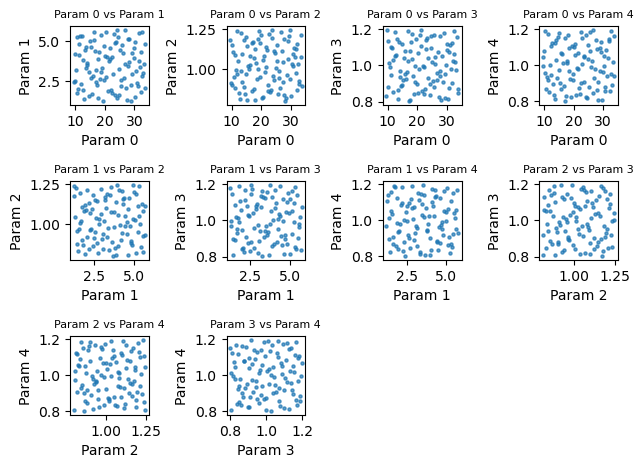

In [19]:
# plot 2-d cross sections of parameter space to visually inspect

# Calculate the ideal number of rows and columns
total_subplots = len(list(itertools.combinations(range(param_list_1.shape[1]), 2)))
ncols = math.ceil(math.sqrt(total_subplots))
nrows = math.ceil(total_subplots / ncols)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
axes = axes.flatten()

# Plot each unique combination of columns
for i, (x_idx, y_idx) in enumerate(itertools.combinations(range(param_list_1.shape[1]), 2)):
    ax = axes[i]
    ax.scatter(param_list_1[:, x_idx], param_list_1[:, y_idx], s=5, alpha=0.7)
    ax.set_xlabel(f'Param {x_idx}')
    ax.set_ylabel(f'Param {y_idx}')
    ax.set_title(f'Param {x_idx} vs Param {y_idx}', fontsize=8)
    ax.set_box_aspect(1)
    # ax.set_aspect('equal', adjustable='datalim')  # Set aspect ratio to be equal

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

By this point, N combinations of (a, c/a, f_r0, f_hp, f_h0) have been generated and saved as 'param_list_1' variable

In [35]:
# Helper functions from helper.py
def norm_rows(v):
    """Normalize rows of array v into unit vectors."""
    if np.all(v==0):
        v_unit = np.array([1,0,0])
    else:
        if v.ndim == 1:
            v_norm = np.linalg.norm(v)
            v_unit = v/v_norm
        
        else:
            v_norm = np.linalg.norm(v, axis=1)
            v_unit = v/v_norm[:,None]
    return v_unit

def random_spherical_cap(cone_angle_deg, cone_direction, num_points):
    """
    Generates a desired number of random points on a spherical cap, 
    given a solid angle and cone direction.

    Parameters
    ----------
    cone_angle_deg : float
        Solid angle of the cone used to define the spherical cap, in units of degrees.
    cone_direction : list
        Direction of cone as a list of vector components [x, y, z].
    num_points : int
        Number of points to generate on spherical cap. 
    
    Returns
    ----------
    points_rot 
        List of random points on spherical cap, as numpy array. 
    """
    # generate points on spherical cap centered at north pole
    cone_angle_rad = cone_angle_deg*(np.pi/180)
    z = np.random.uniform(np.cos(cone_angle_rad), 1, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)
    x = np.sqrt(1-z**2)*np.cos(phi)
    y = np.sqrt(1-z**2)*np.sin(phi)
    points = np.column_stack((x, y, z))

    # rotate points
    north_vector = np.array([0, 0, 1])
    cone_direction_norm = norm_rows(cone_direction)
    u = norm_rows(np.cross(north_vector, cone_direction_norm)) # rotation axis
    rot = np.arccos(np.dot(cone_direction_norm, north_vector)) # rotation angle in radians
    ux = u[0]
    uy = u[1]
    uz = u[2]
    # define rotation matrix
    r11 = np.cos(rot) + (ux**2)*(1 - np.cos(rot))
    r12 = ux*uy*(1 - np.cos(rot)) - uz*np.sin(rot)
    r13 = ux*uz*(1 - np.cos(rot)) + uy*np.sin(rot)
    r21 = uy*ux*(1 - np.cos(rot)) + uz*np.sin(rot)
    r22 = np.cos(rot) + (uy**2)*(1 - np.cos(rot))
    r23 = uy*uz*(1 - np.cos(rot)) - ux*np.sin(rot)
    r31 = uz*ux*(1 - np.cos(rot)) - uy*np.sin(rot)
    r32 = uz*uy*(1 - np.cos(rot)) + ux*np.sin(rot)
    r33 = np.cos(rot) + (uz**2)*(1 - np.cos(rot))
    rot_mat = np.array([[r11, r12, r13], 
                        [r21, r22, r23], 
                        [r31, r32, r33]])
    
    points_rot = np.matmul(rot_mat, points.T)
    points_rot = points_rot.T   

    return points_rot

In [45]:
'''
For each initial parameter combo, 
create n_random perturbed sets of parameters 
'''
# (2) calculate c as a*c/a
param_list_2 = []
for i in range(len(param_list_1)):
    record = copy.deepcopy(param_list_1[i])
    record[1] = record[0] * record[1]
    record = record.tolist()
    param_list_2.append(record)

# (3) add n_arms as parameter
param_list_3 = []
for i in n_arms_list:
    temp = [row + [i] for row in param_list_2]
    param_list_3.extend(temp)

# (4) add random perturbation parameters
# (f_a_1, ..., f_a_n_arms, f_c_1, ..., f_c_n_arms, perturbed s_code)
n_random = 50 # number of random perturbations from "base" state
f_a_min, f_a_max = 0.8, 1.2
f_c_min, f_c_max = 0.8, 1.2
f_a_c_limits = [f_a_min, f_a_max, f_c_min, f_c_max]
count = 0

def perturb_aspect_ratio(n_arms, f_a_c_limits):
    f_a_c = []
    for i in range(n_arms):
        f_a = random.uniform(f_a_c_limits[0], f_a_c_limits[1])
        f_c = random.uniform(f_a_c_limits[2], f_a_c_limits[3])
        f_a_c.append(f_a)
        f_a_c.append(f_c)
    return f_a_c

def get_cone_angle(n_arms):
    # source: http://neilsloane.com/packings/index.html#I
    min_angles = {4 : 109.4712206, 
                  5 : 90.0000000, 
                  6 : 90.0000000, 
                  7 : 77.8695421,
                  8 : 74.8584922,
                  9 : 70.5287794,
                  10 : 66.1468220}
    cone_angle_deg = min_angles[n_arms]/3 # adjust as needed
    return cone_angle_deg

def perturb_s_code(n_arms, s_code_dict):
    s_code = s_code_dict[str(n_arms)]
    s_code_perturbed = []
    cone_angle_deg = get_cone_angle(n_arms)
    for i in range(n_arms):
        cone_direction = np.array([s_code[3*i], s_code[3*i+1], s_code[3*i+2]])
        points_rot = random_spherical_cap(cone_angle_deg, cone_direction, 1)
        pt = points_rot[0]
        s_code_perturbed.extend(pt)
    return s_code_perturbed
    
param_list_final = [] # triple-nested list (i.e., each record is list of list)
for i in range(len(param_list_3)):
    base_params = param_list_3[i] # [a, c, f_r0, f_hp, f_h0, n_arms]
    n_arms = base_params[5] # type int
    for j in range(n_random): 
        param_record = []
        # append base parameters
        param_record.append(base_params)
        # calculate (f_a, f_c) for each bullet
        f_a_c = perturb_aspect_ratio(n_arms, f_a_c_limits)
        param_record.append(f_a_c)
        # calculate perturbed spherical codes
        s_code_perturbed = perturb_s_code(n_arms, s_code_dict)
        param_record.append(s_code_perturbed)
        # append to final parameter list (i.e., triple-nested list)
        param_list_final.append(param_record)

In [46]:
len(param_list_final)

70000

In [49]:
print(len(param_list_final[0][0]))
print(len(param_list_final[0][1]))
print(len(param_list_final[0][2]))

6
8
12


In [50]:
n = len(param_list_final)-1
print(len(param_list_final[n][0]))
print(len(param_list_final[n][1]))
print(len(param_list_final[n][2]))

6
20
30


Save format: "params_N_nrand" where:
- N = # of qmc samples for LHS
- nrand = # of randomly perturbed samples from "base state"

In [55]:
# save final parameter list
params_json = '/glade/u/home/joko/ice3d/output/params.json'
params_pickle = '/glade/u/home/joko/ice3d/output/params.pkl'
# save as json
with open(params_json, 'w') as file:
    json.dump(param_list_final, file, indent=4)
with open(params_pickle, 'wb') as file:
    pickle.dump(param_list_final, file)

In [3]:
params_json = '/glade/u/home/joko/ice3d/output/params.json'
params_pickle = '/glade/u/home/joko/ice3d/output/params.pkl'
# read back params from json 
with open(params_json, 'rb') as file:
    params_json = json.load(file)
# read back params from pkl
with open(params_pickle, 'rb') as file:
    params_pickle = pickle.load(file)

In [4]:
len(params_json)

70000

In [5]:
# create a smaller subset of param dataset
n_subset = 1000
params_subset = random.sample(params_json, n_subset)
len(params_subset)

1000

In [6]:
# save test subset of params
subset_path = '/glade/u/home/joko/ice3d/output/params_subset.json'
# save as json
with open(subset_path, 'w') as file:
    json.dump(params_subset, file, indent=4)

In [2]:
# test read subset of params
subset_path = '/glade/u/home/joko/ice3d/output/params_subset.json'
# load saved json
with open(subset_path, 'rb') as file:
    params_subset = json.load(file)

In [3]:
len(params_subset)

1000